# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

    Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
    Контролировать добросовестность кассиров при продаже алкоголя.

Задача: Построить модель, которая по фотографии определит приблизительный возраст человека. 

Исходные данные: набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import math

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
data_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Всего в сете 7591 фотографий.

In [3]:
labels.sample(10)

,file_name,real_age
4951,004951.jpg,26
1288,001288.jpg,45
4054,004054.jpg,50
3437,003437.jpg,23
4927,004927.jpg,59
2357,002357.jpg,23
598,000598.jpg,40
6993,007004.jpg,27
1909,001909.jpg,9
4511,004511.jpg,31


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Построим диаграму распределение по возрасту.

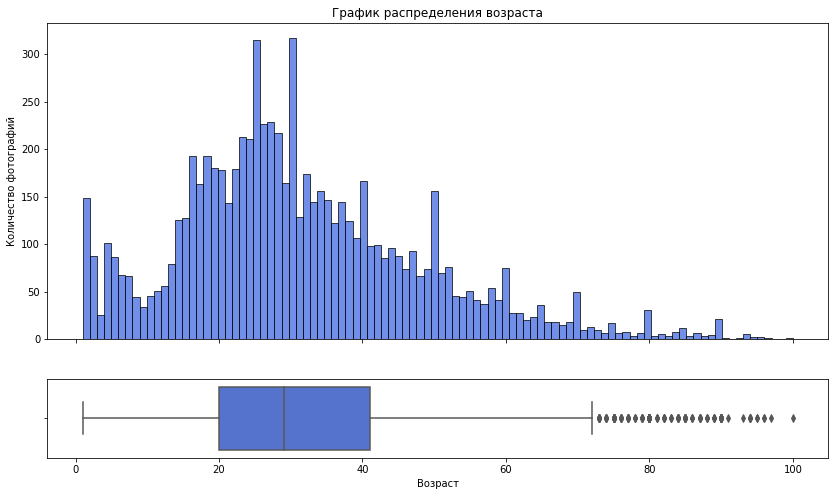

In [5]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.8, .2)}, figsize=(14, 8)) 
sns.histplot(x=labels['real_age'], ax=ax_hist, bins=100, color='royalblue')
sns.boxplot(x=labels['real_age'], ax=ax_box, color='royalblue')
ax_box.set(xlabel='Возраст')
ax_hist.set(ylabel='Количество фотографий')
ax_hist.set(title='График распределения возраста')
plt.show()

Похоже на нормальное распределение, скошенное вправо (кажется, так это называется).
Встречаются пики на некоторых датах. Либо целенаправленно брали фото этого возраста в большем количестве, либо первоначально сет строился на диапазонах возраста, а потом добавили промежуточные значения, либо это объединение разных сетов. Возможны варианты.

Для возрастов старше 70 лет надо добрать данных, если есть необходимость с ними работать.

In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Диапазон значений от 1 до 100, медиана - 29 лет, среднее - 31 год. Большая часть фотографий приходится на возраст 20-41 год.

In [8]:
features, target = next(data_flow)
features.shape

(32, 224, 224, 3)

Загружен батч из 32 фотографий размером 224 на 224 пикселя по три слоя.

In [9]:
nums = random.sample(range(0, 31), 15)
nums

[0, 10, 2, 17, 11, 27, 19, 20, 30, 5, 4, 29, 24, 9, 28]

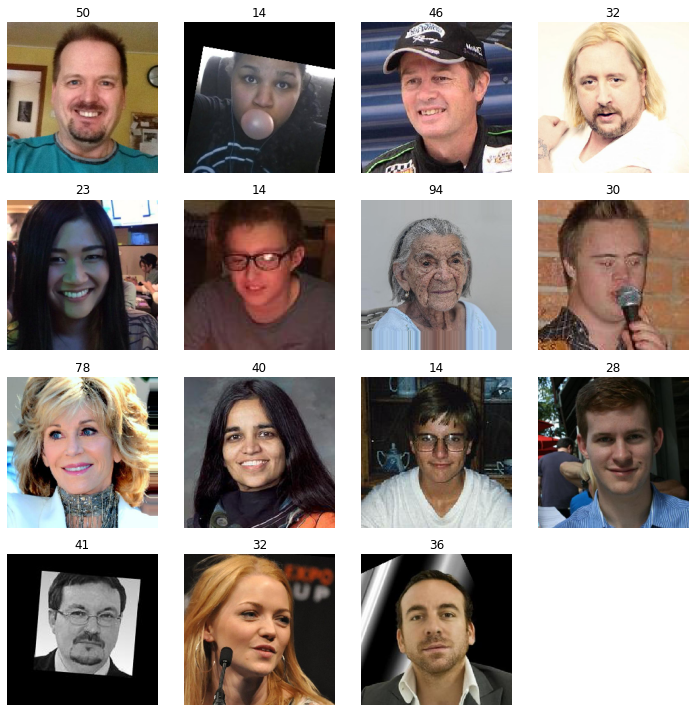

In [10]:
fig = plt.figure(figsize=(10, 10))

for i in range(len(nums)):
    num = nums[i]
    a = 4
    b = math.ceil(len(nums)/4)
    fig.add_subplot(b, a, i + 1,)

    plt.imshow(features[num])
    plt.title(target[num])
    plt.axis('off')

plt.xticks([])
plt.yticks([])
plt.tight_layout()

Фото разного качества, цветные, чёрно-белые, разной чёткости, освещённости, разной направленности взгляд, повороты головы, видимый размер лица относительно размера кадра, дополнительные предметы в кадре перед лицом, очки, серьги, макияж, головные уборы, есть обрезанные изображения, в которых голова не полностью видна. Полагаю, всё это будет вносить помехи в определение возраста. Наверное, они центрированы, потому что нос почти в центре у всех, и некоторые лица вертикализированы - наблюдаем повёрнутые контуры изображений. Может быть, это облегчит задачу.



Итог.

В датасете 7951 фотография размером 224 на 224 пикселя, разного качества изображения. Возможно, нужно раздобыть больше фотографий с разметкой по возрасту. Фотографии пытались привести к похожему виду - они будто центрированы и вертикализированы.

Большее количество данных приходится на возраст 20-41 год, диапазон значений возраста от 1 до 100 лет. Для работы с возрастом больше 70 лет надо добирать данные. Для "пиковых" возрастов хорошо бы пересмотреть значения возраста или выяснить их происхождение и подтвердить. 

## Обучение модели

```python


def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
        
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+"/final_files/",
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25,
        rescale=1./255)
        
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    model.compile(optimizer=Adam(lr=0.0001),
                  loss='mean_squared_error',
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):


    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```



Train for 178 steps, validate for 60 steps

Epoch 1/5

178/178 - 53s - loss: 211.4962 - mae: 10.5340 - val_loss: 855.2049 - val_mae: 24.3624

Epoch 2/5

178/178 - 45s - loss: 73.0246 - mae: 6.4647 - val_loss: 685.0239 - val_mae: 21.0930

Epoch 3/5

178/178 - 44s - loss: 49.2502 - mae: 5.3224 - val_loss: 263.9873 - val_mae: 12.2396

Epoch 4/5

178/178 - 45s - loss: 35.3151 - mae: 4.5319 - val_loss: 106.6715 - val_mae: 7.8656

Epoch 5/5

178/178 - 45s - loss: 26.8940 - mae: 3.9679 - val_loss: 80.3336 - val_mae: 6.7874


60/60 - 11s - loss: 80.3336 - mae: 6.7874

Test MAE: 6.7874


## Анализ обученной модели

Для обучения мы взяли предобученную модель ResNet50 из библиотеки Keras.

Обучив её на наших исходных данных, нам удалось достичь точности определения возраста 3,97 лет на обучающей выборке и 6,79 лет на тестовой. 

Для обеих задач заказчика 6,79 лет может быть нежелательной погрешностью, слишком большая, модель надо развивать дальше.